# Import Packages

In [ ]:
from google.colab import drive
from datetime import datetime
from time import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter

from skimage.transform import rescale,resize
from skimage.feature import hog
from skimage.feature import local_binary_pattern as lbp
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Extract Zip file to local run time (to avoid wasting storage on drive)
# Change the path below as needed - should point to the cleaned data zip file
# !unzip -qq -n /content/drive/MyDrive/Data281Project/cleaned.zip
!unzip -qq -n /content/drive/MyDrive/0281_Computer_Vision/Project/Data281Project/cleaned.zip

In [ ]:
# Set project folder path
project_path = '/content/drive/MyDrive/0281_Computer_Vision/Project/Data281Project'

# Starter code

Checking if the cleaned data has been loaded correctly

In [ ]:
# Use the Kaggle dataset to find the number of image to find subregions
count_base = 'content/cleaned_dataset/'
data_count = {}
img_path = os.listdir(count_base)

for country in img_path:
    num_count = len(os.listdir(count_base+country))
    data_count[str(country)] =num_count
country_name_count = pd.DataFrame(data={'count':data_count.values()},index = data_count.keys())

country_name_count

,count
western_europe,7828
sub_saharan_africa,7828
southern_europe,7828
south_eastern_asia,7828
eastern_asia,7828
northern_europe,7828
northern_america,7828
latin_america_and_the_caribbean,7828
eastern_europe,7828
australia_and_new_zealand,7828


In [ ]:
# Create mapping from labels to image_path
label_img = {}
for label in country_name_count.index:
    label_img[label] = []
    img_path = os.listdir(f'{count_base}{label}')
    img_path = [f'{count_base}{label}/'+i for i in img_path]
    label_img[label] += img_path

print(label_img.keys())
print(label_img['eastern_asia'][0])

dict_keys(['western_europe', 'sub_saharan_africa', 'southern_europe', 'south_eastern_asia', 'eastern_asia', 'northern_europe', 'northern_america', 'latin_america_and_the_caribbean', 'eastern_europe', 'australia_and_new_zealand'])
content/cleaned_dataset/eastern_asia/7741.jpg


## Example images

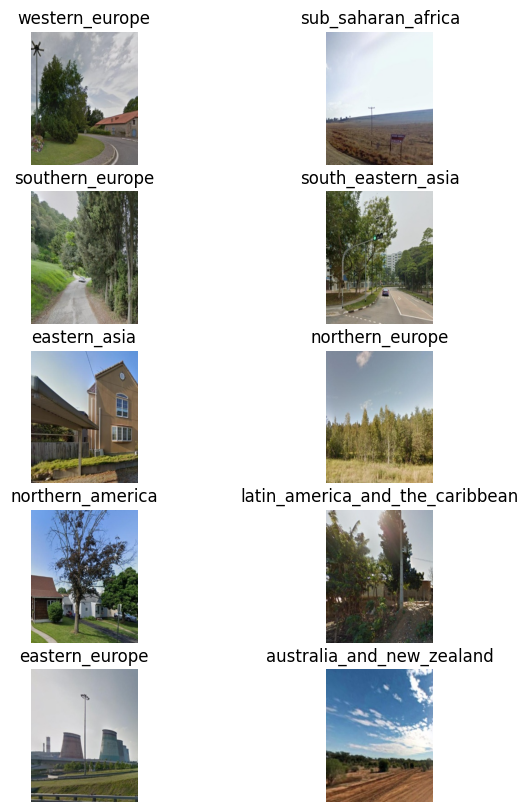

In [ ]:

fig,axs = plt.subplots(5,2,figsize=(7,10))
for i, (label, img_list) in enumerate(label_img.items()):
    # Randomly sample image
    rand_path = np.random.choice(img_list)
    rand_pic = cv2.imread(rand_path)
    rand_pic = cv2.cvtColor(rand_pic, cv2.COLOR_BGR2RGB) # Converting back to correct color format cv.COLOR_BGR2GRAY
    axs[i//2,i%2].imshow(rand_pic)
    axs[i//2,i%2].axis('off')
    axs[i//2,i%2].set_title(label)

# Train-Val-Test Split

Ratio: 7-2-1

In [ ]:
import shutil
# Stratified Sampling
validate_prop = 0.2
test_prop = 0.1
seed = 281
np.random.seed(seed)
dataset_path = 'content/cleaned_dataset'

train_imgs,validate_imgs,test_imgs = [],[],[]

if not os.path.exists('dataset_dir'):
    os.mkdir('dataset_dir')
if not os.path.exists('dataset_dir/train'):
    os.mkdir('dataset_dir/train')
if not os.path.exists('dataset_dir/validate'):
    os.mkdir('dataset_dir/validate')
if not os.path.exists('dataset_dir/test'):
    os.mkdir('dataset_dir/test')

for label in os.listdir(dataset_path):
    # List all images
    class_path = f'{dataset_path}/{label}'
    im_path = os.listdir(class_path)
    im_path = [f'{class_path}/{i}' for i in im_path]

    # We don't shuffle the paths for the general split so we can sample the 2 halves of the images together
    # np.random.shuffle(im_path)
    # For Debugging: LIMITING THE DATSET SIZE
    # im_path = im_path[:2000]

    # Split the first 70% for train
    train_pos = int(len(im_path)*(1-(validate_prop+test_prop)))
    validate_pos = train_pos+int(len(im_path)*validate_prop)
    train_path = im_path[:train_pos]
    val_path = im_path[train_pos:validate_pos]
    test_path = im_path[validate_pos:]

    if not os.path.exists(f'dataset_dir/train/{label}'):
        os.mkdir(f'dataset_dir/train/{label}')
        for i in train_path:
            shutil.copy(i,f'dataset_dir/train/{label}')

    if not os.path.exists(f'dataset_dir/validate/{label}'):
        os.mkdir(f'dataset_dir/validate/{label}')
        for i in val_path:
            shutil.copy(i,f'dataset_dir/validate/{label}')

    if not os.path.exists(f'dataset_dir/test/{label}'):
        os.mkdir(f'dataset_dir/test/{label}')
        for i in test_path:
            shutil.copy(i,f'dataset_dir/test/{label}')



    train_imgs+=train_path
    validate_imgs+=val_path
    test_imgs+=test_path


In [ ]:
len(train_imgs)

54790

In [ ]:
len(validate_imgs)

15650

# Feature Extraction and Checkpoints

In [ ]:
import skimage.io as skio
from skimage.color import rgb2gray
from scipy.spatial import distance

from sklearn.cluster import KMeans
# Feature extraction_pipeline
# General Preprocessing
def read_img(img_list):
    return skio.imread_collection(img_list)

# Get Hog
def get_hog(im_arr,pixels_per_cell=None,orientations=5,cells_per_block=(1,1)):
    hog_f_arr = []
    for im in im_arr:
        if pixels_per_cell is None:
            pixels_per_cell = (im.shape[1]/12,im.shape[0]/15)
        f = hog(im,pixels_per_cell=pixels_per_cell,visualize=False,orientations=orientations,channel_axis=-1,cells_per_block=cells_per_block)
        hog_f_arr.append(f)
    return np.array(hog_f_arr)

def compute_hist(lbp):
    hist = []
    for l in lbp:
        h,_ = np.histogram(l,bins=20,range=[0,256])
        hist.append(h/h.sum())
    return np.array(hist)

# Get LBP
def get_lbp(im_arr,P=8,R=10):
    lbp_f_arr = []
    gray_im_arr = rgb2gray(im_arr)
    for im in gray_im_arr:
        lbp_f_arr.append(lbp(im,P=P,R=R).ravel())
    return compute_hist(np.array(lbp_f_arr))



## Training Set

In [ ]:
train_folder = 'dataset_dir/train'
class_folder = os.listdir(train_folder)

lbp_features = []
hog_features = []
labels = []
img_list_train = []
for l in class_folder:
    img_list = os.listdir(f'{train_folder}/{l}')
    img_list = [f'{train_folder}/{l}/{i}' for i in img_list]
    #img_list = img_list[:700]
    #print(len(img_list))
    im_db = read_img(img_list)
    lbp_features.append(get_lbp(im_db))
    hog_features.append(get_hog(im_db))
    labels.append(np.repeat(l,len(img_list)))
    img_list_train.append(img_list)

#save_path = '/content/drive/MyDrive/Data281Project/preprocessed_train/'

save_path = project_path + '/preprocessed_train_no_reduction/'
np.save(f'{save_path}img_list.npy',np.concatenate(img_list_train))
np.save(f'{save_path}X_lbp.npy',np.row_stack(lbp_features))
np.save(f'{save_path}X_hog.npy',np.row_stack(hog_features))
np.save(f'{save_path}y.npy',np.concatenate(labels))


## Validation Set

In [ ]:
validate_folder = 'dataset_dir/validate'
class_folder = os.listdir(validate_folder)

lbp_features = []
hog_features = []
labels = []
img_list_val = []
for l in class_folder:
    img_list = os.listdir(f'{validate_folder}/{l}')
    img_list = [f'{validate_folder}/{l}/{i}' for i in img_list]
    #img_list = img_list[:200]
    #print(len(img_list))
    # img_list = img_list[:10]
    im_db = read_img(img_list)
    lbp_features.append(get_lbp(im_db))
    hog_features.append(get_hog(im_db))
    labels.append(np.repeat(l,len(img_list)))
    img_list_val.append(img_list)

#save_path = '/content/drive/MyDrive/Data281Project/preprocessed_validate/'
save_path = project_path + '/preprocessed_validate_no_reduction/'
np.save(f'{save_path}img_list.npy',np.concatenate(img_list_val))
np.save(f'{save_path}y.npy',np.concatenate(labels))
np.save(f'{save_path}X_lbp.npy',np.row_stack(lbp_features))
np.save(f'{save_path}X_hog.npy',np.row_stack(hog_features))


## Test Set

In [ ]:
test_folder = 'dataset_dir/test'
class_folder = os.listdir(test_folder)

lbp_features = []
hog_features = []
labels = []
img_list_test = []
for l in class_folder:
    img_list = os.listdir(f'{test_folder}/{l}')
    img_list = [f'{test_folder}/{l}/{i}' for i in img_list]
    #img_list = img_list[:100]
    #print(len(img_list))
    im_db = read_img(img_list)
    lbp_features.append(get_lbp(im_db))
    hog_features.append(get_hog(im_db))
    labels.append(np.repeat(l,len(img_list)))
    img_list_test.append(img_list)


# save_path = '/content/drive/MyDrive/Data281Project/preprocessed_test/'
save_path = project_path + '/preprocessed_test_no_reduction/'
np.save(f'{save_path}img_list.npy',np.concatenate(img_list_test))
np.save(f'{save_path}y.npy',np.concatenate(labels))
np.save(f'{save_path}X_lbp.npy',np.row_stack(lbp_features))
np.save(f'{save_path}X_hog.npy',np.row_stack(hog_features))


# Load Train/Val Checkpoint here

In [ ]:
# Load features file

# Train
hog_train_X = np.load(project_path + '/preprocessed_train_no_reduction/X_hog.npy')
lbp_train_X = np.load(project_path + '/preprocessed_train_no_reduction/X_lbp.npy')
train_y = np.load(project_path + '/preprocessed_train_no_reduction/y.npy')

# Validation
hog_val_X = np.load(project_path + '/preprocessed_validate_no_reduction/X_hog.npy')
lbp_val_X = np.load(project_path + '/preprocessed_validate_no_reduction/X_lbp.npy')
val_y = np.load(project_path + '/preprocessed_validate_no_reduction/y.npy')


# PCA/t-SNE Analysis

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

hog_pca_pipe = Pipeline([('scaler',RobustScaler()),
 ('pca',PCA(n_components=2))])

X_hog_pca = hog_pca_pipe.fit_transform(hog_train_X.astype(np.float32))

hog_tsne_pipe = Pipeline([('scaler',RobustScaler()),
 ('tsne',TSNE(n_iter=5000,n_components=2,random_state=1,method='barnes_hut'))])

X_hog_tsne = hog_tsne_pipe.fit_transform(hog_train_X.astype(np.float32))

lbp_pca_pipe = Pipeline([('scaler',RobustScaler()),
  ('pca', PCA(n_components=2))])

X_lbp_pca = lbp_pca_pipe.fit_transform(lbp_train_X.astype(np.float32))

lbp_tsne_pipe = Pipeline([('scaler',RobustScaler()),
  ('tsne',TSNE(n_iter=5000,n_components=2,random_state=1,method='barnes_hut'))])

X_lbp_tsne = lbp_tsne_pipe.fit_transform(lbp_train_X.astype(np.float32))


KeyboardInterrupt: 

In [ ]:
import seaborn as sns

# Plot methods
country_id_mapping = {v:k for k,v in dict(enumerate(np.unique(train_y))).items()}

def plot_classes(X, y, ax, title):

  # color code each cluster (person ID)
  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]
  # project the features into 2 dimensions

  for i,k in country_id_mapping.items():
    #print(i)
    sns.scatterplot(x = X[y==i, 0], y = X[y==i, 1],ax=ax)

  ax.set_title(title)



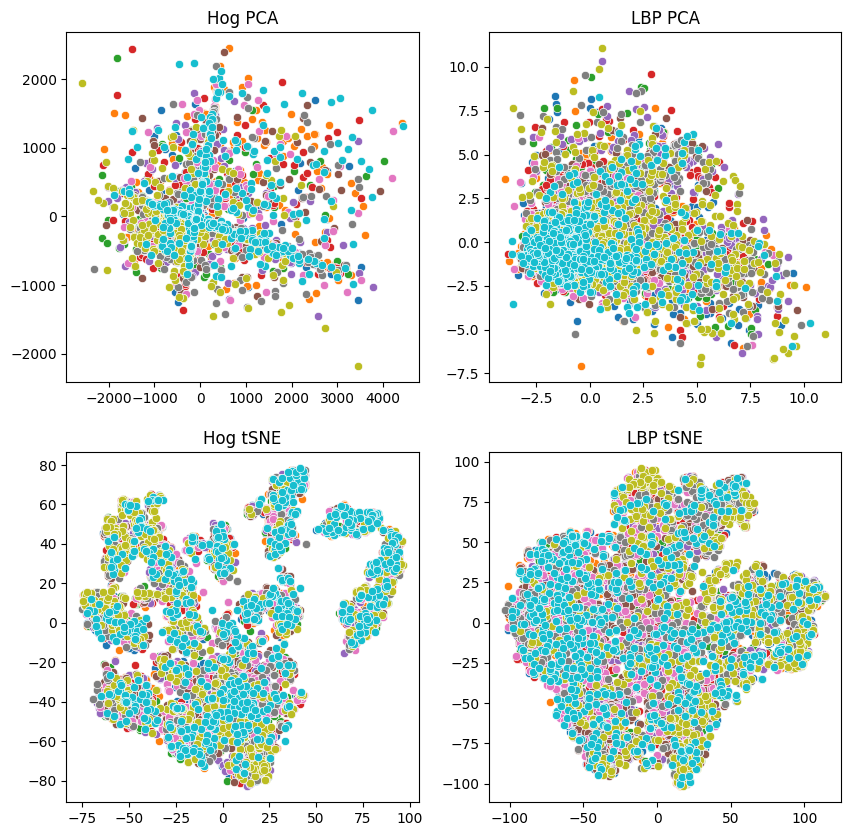

In [ ]:
# plot results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

# plot just a sample of each
#sample_size = 1000
plot_classes(X_hog_pca, train_y, ax[0,0], title='Hog PCA')
plot_classes(X_lbp_pca, train_y, ax[0,1], title='LBP PCA')
plot_classes(X_hog_tsne, train_y, ax[1,0], title='Hog tSNE')
plot_classes(X_lbp_tsne, train_y, ax[1,1], title='LBP tSNE')

plt.show()

In [ ]:
lbp_train_X.shape

(7000, 20)

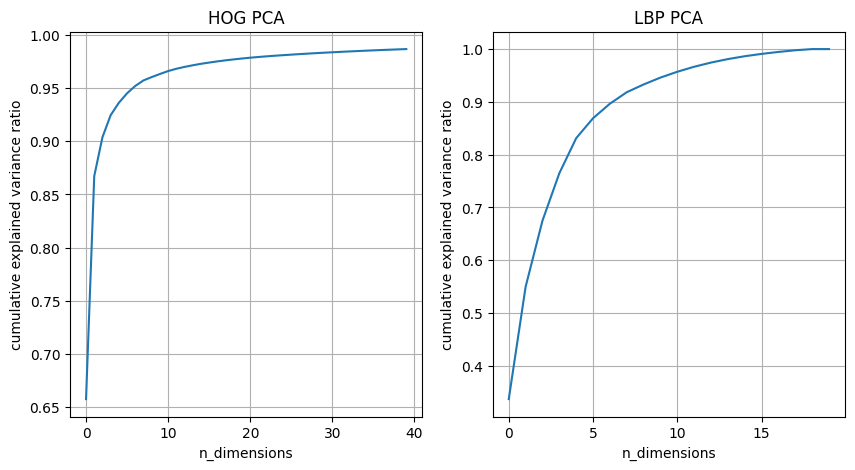

In [ ]:
# PCA Curves
hog_pca_pipe = Pipeline([('scaler',RobustScaler()),
 ('pca',PCA(n_components=40))])

X_hog_pca = hog_pca_pipe.fit_transform(hog_train_X.astype(np.float32))


lbp_pca_pipe = Pipeline([('scaler',RobustScaler()),
  ('pca', PCA(n_components=20))])

X_lbp_pca = lbp_pca_pipe.fit_transform(lbp_train_X.astype(np.float32))

def plot_pca_curve(pca_model, label, ax, title):
  ax.plot(np.cumsum(pca_model.explained_variance_ratio_),label=label)
  ax.set_xlabel('n_dimensions')
  ax.set_ylabel('cumulative explained variance ratio')
  ax.set_title(title)
  ax.grid(visible=True)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plot_pca_curve(hog_pca_pipe['pca'], 'hog_features', ax[0], title='HOG PCA')
plot_pca_curve(lbp_pca_pipe['pca'], 'lbp_features', ax[1], title='LBP PCA')

plt.show()

# Classifiers

In [ ]:
# Confusion Matrix Plot
import seaborn as sns

def plot_cm(model, X, y, title="Confusion Matrix"):
  predictions = model.predict(X)
  conf_mat = confusion_matrix(y, predictions)
  sns.heatmap(conf_mat/np.sum(conf_mat),annot=True,fmt='.1%',cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y)
            )
  plt.title(title)
  plt.show()

def plot_cm_pred(y_pred, y, title="Confusion Matrix"):
  conf_mat = confusion_matrix(y, y_pred)
  sns.heatmap(conf_mat/np.sum(conf_mat),annot=True,fmt='.1%',cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y)
            )
  plt.title(title)
  plt.show()

## Logistic Regression

In [ ]:
# HOG Pipeline
hog_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=100))
])

hog_lr.fit(hog_train_X, train_y)
print("Training Accuracy: ",hog_lr.score(hog_train_X, train_y))
print("Validation Accuracy: ",hog_lr.score(hog_val_X, val_y))

Training Accuracy:  0.44757142857142856
Validation Accuracy:  0.1515


In [ ]:
# Confusion Matrix
# fig, ax = plt.subplots(nrows=1, ncols=2)
# ax[0] = ConfusionMatrixDisplay.from_estimator(hog_lr, hog_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# ax[0].set_title("Training")
# ax[1] = ConfusionMatrixDisplay.from_estimator(hog_lr, hog_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
# ax[0].set_title("Validation")
# plt.show()

plot_cm(hog_lr, hog_train_X, train_y, "Training")
plot_cm(hog_lr, hog_val_X, val_y, "Validation")

NameError: name 'hog_lr' is not defined

In [ ]:
hog_pca_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=10)),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=800))
])

hog_pca_lr.fit(hog_train_X, train_y)
print("Training Accuracy: ",hog_pca_lr.score(hog_train_X, train_y))
print("Validation Accuracy: ",hog_pca_lr.score(hog_val_X, val_y))

Training Accuracy:  0.15814285714285714
Validation Accuracy:  0.146


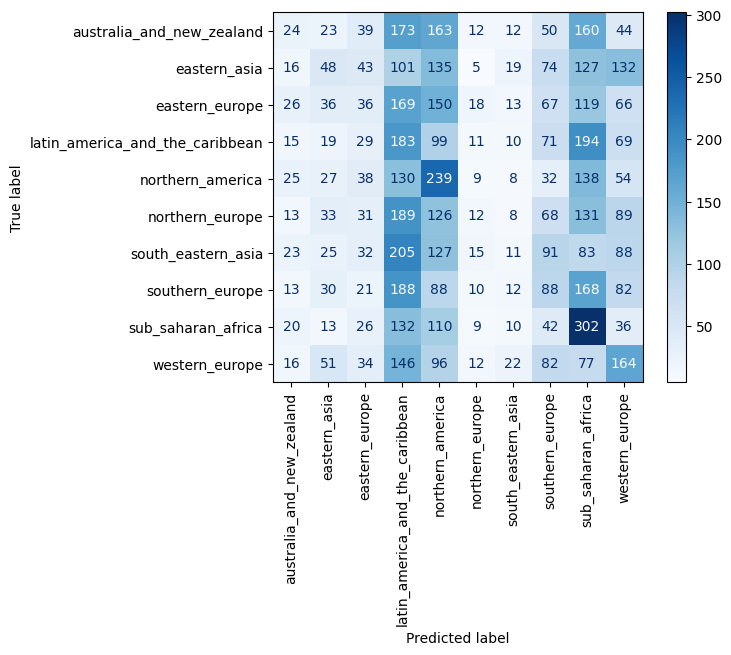

In [ ]:
# hog_pca_lr_cm_train = ConfusionMatrixDisplay.from_estimator(hog_pca_lr, hog_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()
plot_cm(hog_pca_lr, hog_train_X, train_y, "Training")
plot_cm(hog_pca_lr, hog_val_X, val_y, "Validation")

In [ ]:
# LBP Pipeline
lbp_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=800))
])

lbp_lr.fit(lbp_train_X, train_y)
print("Training Accuracy: ",lbp_lr.score(lbp_train_X, train_y))
print("Validation Accuracy: ",lbp_lr.score(lbp_val_X, val_y))

Training Accuracy:  0.205
Validation Accuracy:  0.1755


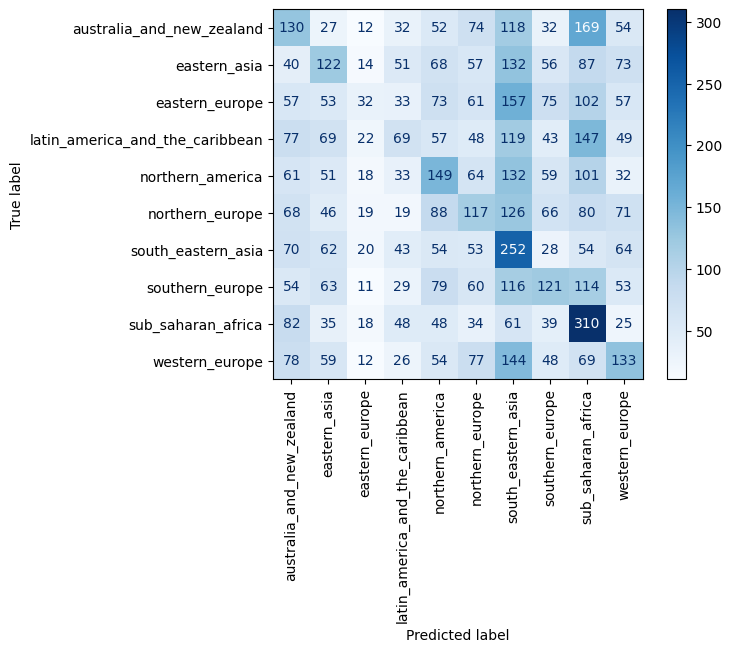

In [ ]:
# lbp_lr_cm_train = ConfusionMatrixDisplay.from_estimator(lbp_lr, lbp_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()
plot_cm(lbp_lr, lbp_train_X, train_y, "Training")
plot_cm(lbp_lr, lbp_val_X, val_y, "Validation")

In [ ]:
lbp_pca_lr = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=10)),
    ('clf', LogisticRegression(solver="newton-cholesky",
                                  max_iter=800))
])

lbp_pca_lr.fit(lbp_train_X, train_y)
print("Training Accuracy: ",lbp_pca_lr.score(lbp_train_X, train_y))
print("Validation Accuracy: ",lbp_pca_lr.score(lbp_val_X, val_y))

Training Accuracy:  0.18414285714285714
Validation Accuracy:  0.1755


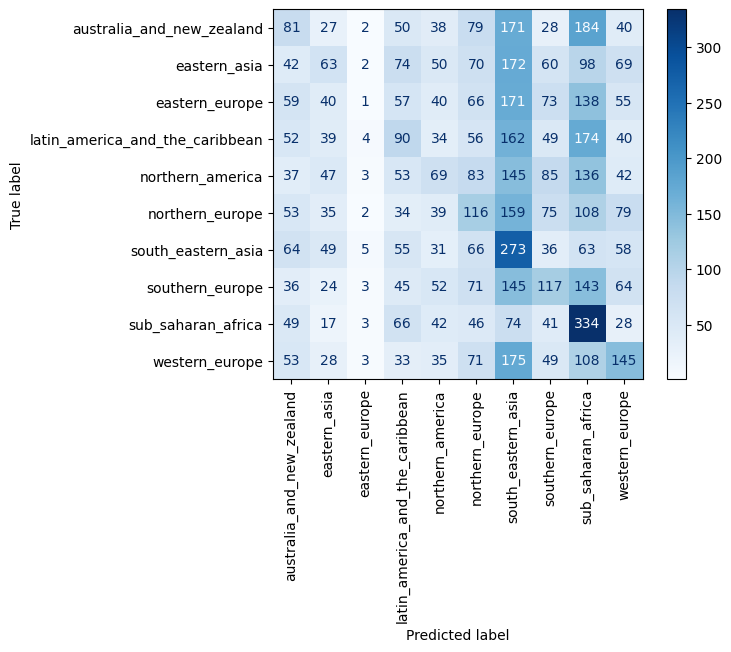

In [ ]:
# lbp_pca_lr_cm_train = ConfusionMatrixDisplay.from_estimator(lbp_pca_lr, lbp_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()

plot_cm(lbp_pca_lr, lbp_train_X, train_y, "Training")
plot_cm(lbp_pca_lr, lbp_val_X, val_y, "Validation")

## HistGradientBoost

In [ ]:
hog_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', HistGradientBoostingClassifier(early_stopping=True,
                                               tol=100.0))
])

hog_hgb.fit(hog_train_X, train_y)
print("Training Accuracy: ",hog_hgb.score(hog_train_X, train_y))
print("Validation Accuracy: ",hog_hgb.score(hog_val_X, val_y))

Training Accuracy:  0.7384285714285714
Validation Accuracy:  0.1665


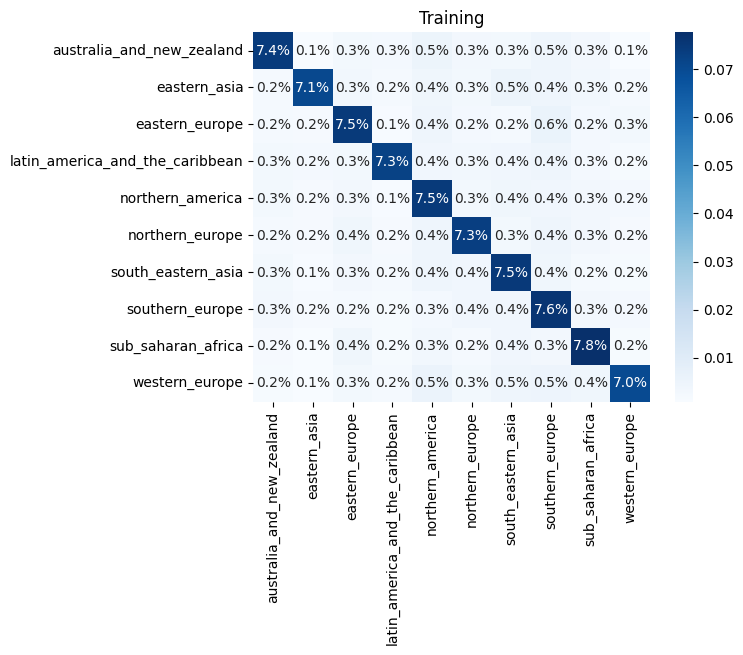

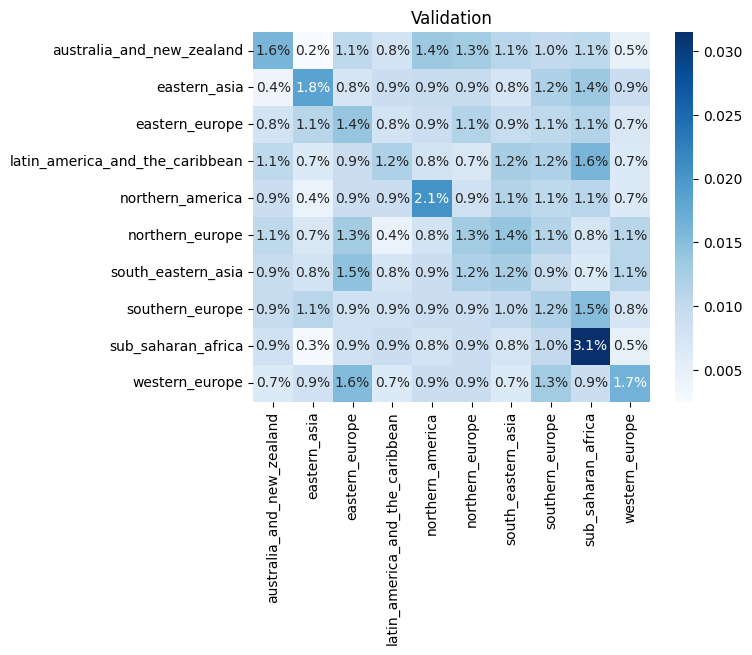

In [ ]:
plot_cm(hog_hgb, hog_train_X, train_y, "Training")
plot_cm(hog_hgb, hog_val_X, val_y, "Validation")
# hog_hgb_cm_train = ConfusionMatrixDisplay.from_estimator(hog_hgb, hog_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# hog_hgb_cm_val = ConfusionMatrixDisplay.from_estimator(hog_hgb, hog_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()

In [ ]:
hog_pca_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=20)),
    ('clf', HistGradientBoostingClassifier(early_stopping=True,
                                               tol=10.0))
])

hog_pca_hgb.fit(hog_train_X, train_y)
print("Training Accuracy: ",hog_pca_hgb.score(hog_train_X, train_y))
print("Validation Accuracy: ",hog_pca_hgb.score(hog_val_X, val_y))

Training Accuracy:  0.5311428571428571
Validation Accuracy:  0.1515


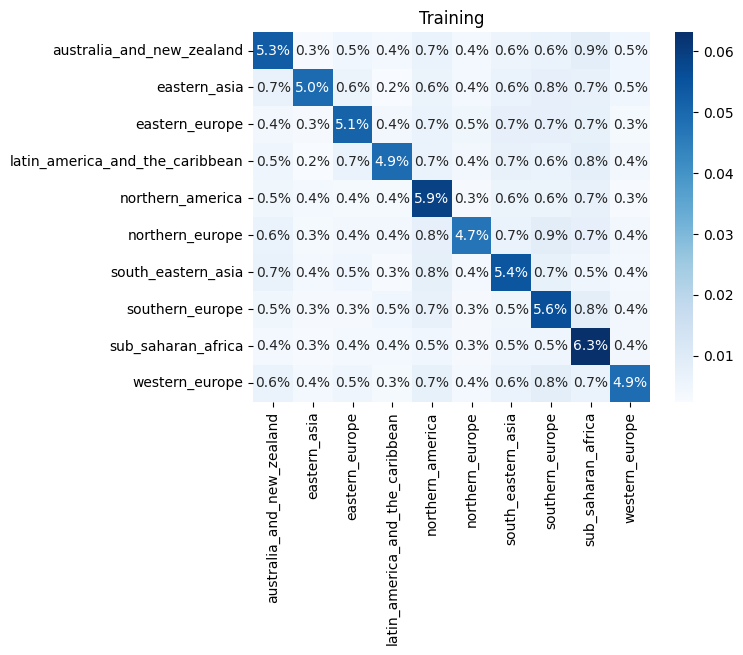

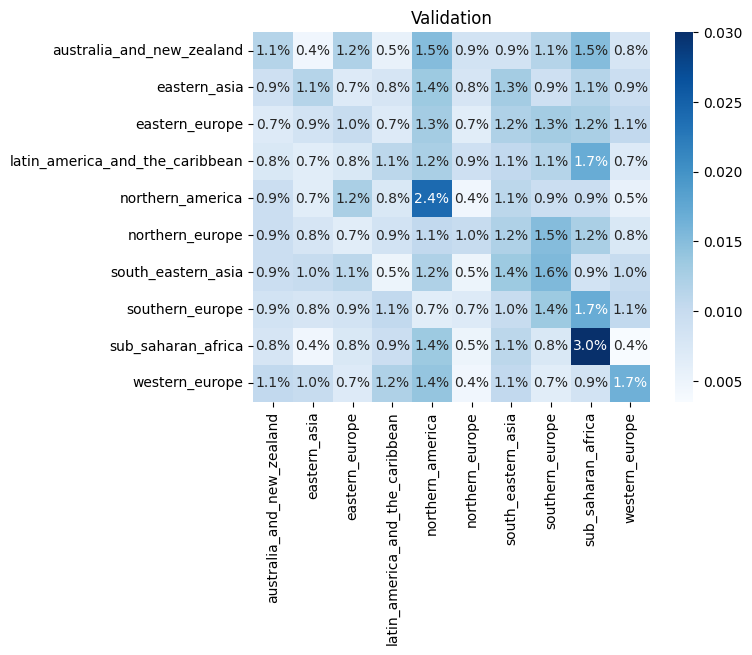

In [ ]:
plot_cm(hog_pca_hgb, hog_train_X, train_y, "Training")
plot_cm(hog_pca_hgb, hog_val_X, val_y, "Validation")
# hog_pca_hgb_cm_train = ConfusionMatrixDisplay.from_estimator(hog_pca_hgb, hog_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# hog_pca_hgb_cm_val = ConfusionMatrixDisplay.from_estimator(hog_pca_hgb, hog_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
plt.show()

In [ ]:
lbp_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('hgb_clf', HistGradientBoostingClassifier(early_stopping=True))
])

lbp_hgb.fit(lbp_train_X, train_y)
print("Training Accuracy: ",lbp_hgb.score(lbp_train_X, train_y))
print("Validation Accuracy: ",lbp_hgb.score(lbp_val_X, val_y))

Training Accuracy:  0.726
Validation Accuracy:  0.167


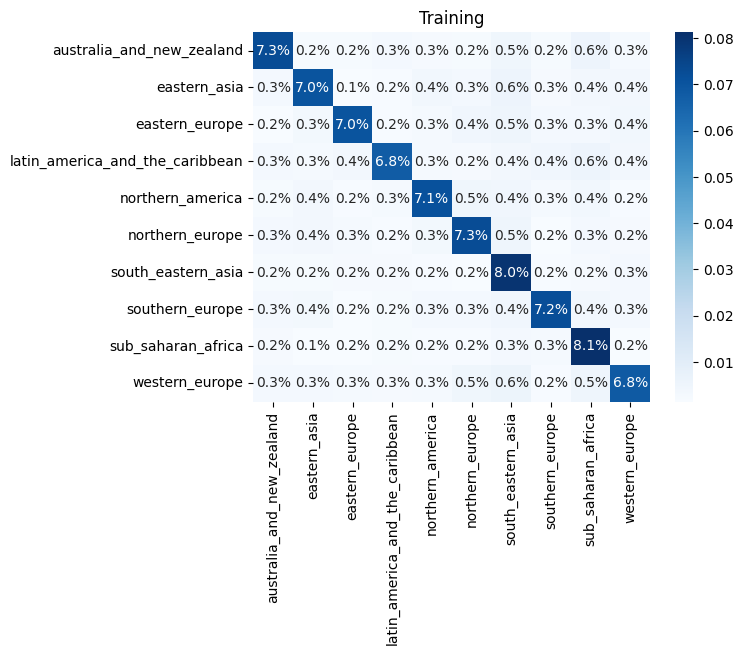

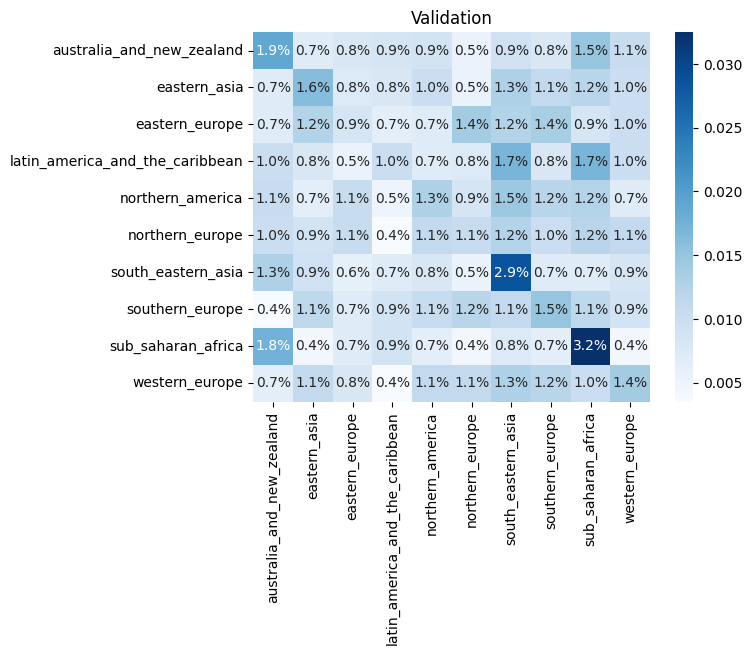

In [ ]:
plot_cm(lbp_hgb, lbp_train_X, train_y, "Training")
plot_cm(lbp_hgb, lbp_val_X, val_y, "Validation")
# lbp_hgb_cm_train = ConfusionMatrixDisplay.from_estimator(lbp_hgb, lbp_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# lbp_hgb_cm_val = ConfusionMatrixDisplay.from_estimator(lbp_hgb, lbp_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()

In [ ]:
lbp_pca_hgb = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=20)),
    ('hgb_clf', HistGradientBoostingClassifier(early_stopping=True))
])

lbp_pca_hgb.fit(lbp_train_X, train_y)
print("Training Accuracy: ",lbp_pca_hgb.score(lbp_train_X, train_y))
print("Validation Accuracy: ",lbp_pca_hgb.score(lbp_val_X, val_y))

Training Accuracy:  0.6491428571428571
Validation Accuracy:  0.1655


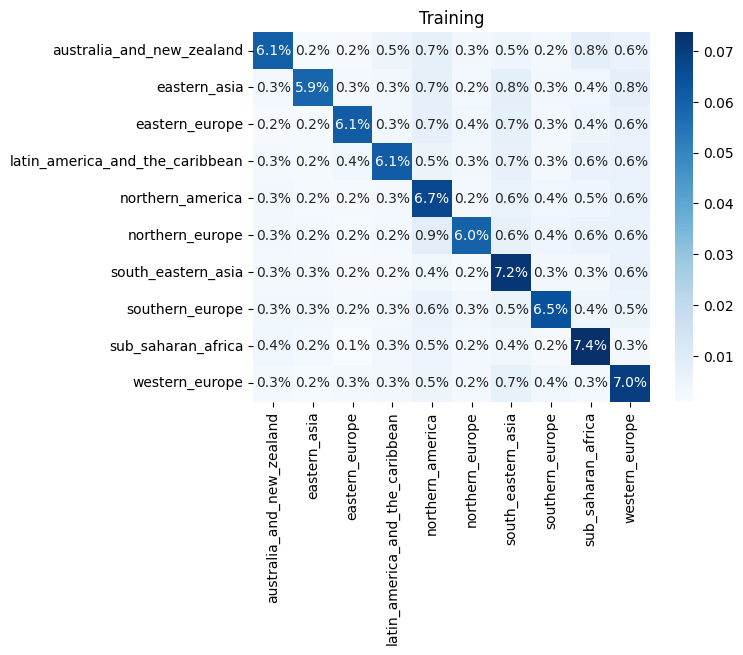

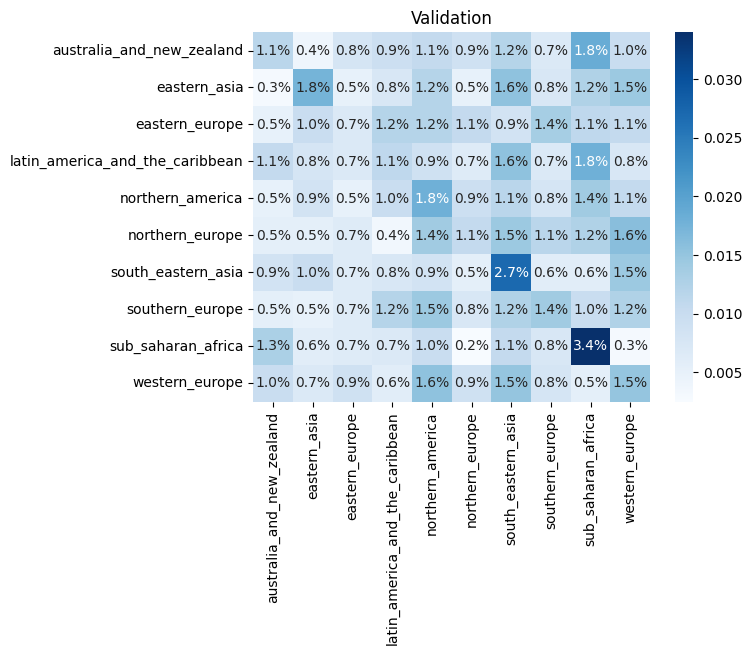

In [ ]:
plot_cm(lbp_pca_hgb, lbp_train_X, train_y, "Training")
plot_cm(lbp_pca_hgb, lbp_val_X, val_y, "Validation")

# lbp_pca_hgb_cm_train = ConfusionMatrixDisplay.from_estimator(lbp_pca_hgb, lbp_train_X, train_y, cmap='Blues', xticks_rotation='vertical')
# lbp_pca_hgb_cm_val = ConfusionMatrixDisplay.from_estimator(lbp_pca_hgb, lbp_val_X, val_y, cmap='Blues', xticks_rotation='vertical')
# plt.show()

# CNN: DenseNet121

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,Dense,Conv2D,Dropout,BatchNormalization,Flatten,GlobalAveragePooling2D,MaxPooling2D,AveragePooling2D,GaussianNoise,RandomCrop,InputLayer,Activation,Resizing
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,AdamW
from tensorflow.keras.utils import plot_model

train_datagen = ImageDataGenerator(rescale=1./255,height_shift_range=0.0,rotation_range=0,)
validate_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Pre-trained Models
from keras.applications import EfficientNetB0,DenseNet121
eff_net = EfficientNetB0(include_top=False,
                   weights='imagenet',
                   input_shape=(224,224,3,),
                   )
densenet = DenseNet121(include_top=False,
                   weights='imagenet',
                   input_shape=(224,224,3,),
                   )

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
def make_pretrained_model(input_shape=(293,235,3,),dense_size=32,num_classes=10,dropout=0.2,pretrained_model=eff_net):
    inputs = Input(shape=input_shape)
    # Crop to square image
    crop = RandomCrop(height=224,width=224)(inputs)

    # Pretrained Feature Extractions
    ## Freezing pretrained_model weights
    for l in pretrained_model.layers[:-10]:
        l.trainable = False

    pretrained = pretrained_model(crop)
    ## freeze layers


    # Global pool
    flatten = GlobalAveragePooling2D()(pretrained)
    dropout = Dropout(dropout)(flatten)
    # Dense layers
    hidden = Dense(dense_size,activation='relu')(dropout)
    outputs = Dense(num_classes,activation='softmax')(hidden)

    model = Model(inputs=[inputs],outputs=[outputs])
    return model

In [ ]:
pretrained_model = make_pretrained_model(pretrained_model=densenet)
pretrained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 293, 235, 3)]     0         
                                                                 
 random_crop (RandomCrop)    (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 32)                32800     
                                                             

In [ ]:
if not os.path.exists(f'{project_path}/cnn_weights/'):
    os.mkdir(f'{project_path}/cnn_weights/')
model_name = 'densenet121_tuned_v2.keras'
callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=f'{project_path}/cnn_weights/{model_name}',save_best_only=True,
                                               monitor='val_acc',verbose=2)

pretrained_model.compile(optimizer=AdamW(learning_rate=1e-4),loss='categorical_crossentropy',metrics='acc')

In [ ]:
train_generator = train_datagen.flow_from_directory('dataset_dir/train',batch_size=64,target_size=(293,235),shuffle=True)
validate_generator = validate_datagen.flow_from_directory('dataset_dir/validate',batch_size=64,target_size=(293,235))

history = pretrained_model.fit(train_generator,validation_data=validate_generator,epochs=30,callbacks=[callbacks],shuffle=True)

Found 54790 images belonging to 10 classes.
Found 15650 images belonging to 10 classes.
Epoch 1/30
750/857 [=========================>....] - ETA: 20:10 - loss: 2.2414 - acc: 0.1829

KeyboardInterrupt: 

In [ ]:
train_generator.reset()
steps_train = train_generator.n//64

y_train_preds,y_train = [],[]
for i in range(steps_train):
    x,y = train_generator.next()
    y_train_preds.extend(pretrained_model.predict(x).argmax(axis=1))
    y_train.extend(y.argmax(axis=1))

In [ ]:
# Confusion Matrix
labels_train = list(train_generator.class_indices.keys())
conf_mat_train = confusion_matrix(y_train,y_train_preds)
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat_train/np.sum(conf_mat_train),annot=True,fmt='.2%',cmap='Blues',
            xticklabels=labels_train,
            yticklabels=labels_train
            )
plt.title("Training")

In [ ]:
validate_generator.reset()
steps = validate_generator.n//64

y_val_preds,y_val = [],[]
for i in range(steps):
    x,y = validate_generator.next()
    y_val_preds.extend(pretrained_model.predict(x).argmax(axis=1))
    y_val.extend(y.argmax(axis=1))


In [ ]:
# Confusion Matrix
labels = list(validate_generator.class_indices.keys())
conf_matrix = confusion_matrix(y_val,y_val_preds)
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix/np.sum(conf_matrix),annot=True,fmt='.2%',cmap='Blues',
            xticklabels=labels,
            yticklabels=labels
            )
plt.title("Validation")

## CNN - PCA and t-SNE

In [ ]:
clone_model = tf.keras.models.Model(inputs=pretrained_model.inputs,outputs = pretrained_model.layers[3].output)
feat_generator = train_datagen.flow_from_directory('dataset_dir/train',batch_size=64,target_size=(293,235),shuffle=False)

cnn_features_train = []
y_train = []
for i in range(steps):
    x,y = feat_generator.next()
    y_train.extend(y.argmax(axis=1))
    cnn_features_train.extend(clone_model.predict(x))



In [ ]:
val_feat_gen = validate_datagen.flow_from_directory('dataset_dir/validate',batch_size=64,target_size=(293,235))
cnn_features_val = []
y_val = []
for i in range(steps):
    x,y = val_feat_gen.next()
    y_val.extend(y.argmax(axis=1))
    cnn_features_val.extend(clone_model.predict(x))


In [ ]:
cnn_pca = PCA(n_components=500)
cnn_pca.fit(np.row_stack(cnn_features_train))
plt.plot(np.cumsum(cnn_pca.explained_variance_ratio_),label='cnn_features')
plt.xlabel('n_dimensions')
plt.ylabel('cumulative explained variance ratio')
plt.legend()
plt.grid()
plt.title('PCA of Flattened CNN Features')
plt.show()

In [ ]:
cnn_pca_vis = PCA(n_components=2)
cnn_pca_features = cnn_pca_vis.fit_transform(np.row_stack(cnn_features_train))

cnn_tsne = TSNE(n_components=2,random_state=281)
cnn_tsne_features = cnn_tsne.fit_transform(cnn_features_train)



In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_classes(cnn_pca_features, np.array(y_train), ax[0], title = 'CNN PCA')
plot_classes(cnn_tsne_features, np.array(y_train), ax[1], title='CNN tSNE')

plt.show()

# Grid Search

In [ ]:
from sklearn.experimental import enable_halving_search_cv

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV,RandomizedSearchCV
from sklearn.metrics import make_scorer,top_k_accuracy_score,f1_score
f1_scorer = make_scorer(f1_score,average='weighted')

In [ ]:
clf_pca_param_grid = {
    'pca__n_components':[5,10,20,30],
    'clf__max_iter':[50, 100, 200, 500],
    'clf__tol':[1,10,100]
    }


clf_param_grid = {
    'clf__max_iter':[50, 100, 200, 500],
    'clf__tol':[1,10,100]
}


In [ ]:
# Stacking Train and validation sets together
hog_X = np.vstack([hog_train_X, hog_val_X])
lbp_X = np.vstack([lbp_train_X, lbp_val_X])
cnn_X = np.vstack([np.array(cnn_features_train), np.array(cnn_features_val)])

clf_y = np.vstack([train_y, val_y])
cnn_y = np.vstack([np.array(y_train), np.array(y_val)])

(9000, 770)

In [ ]:
hog_lr_grid_search = GridSearchCV(hog_lr, clf_param_grid, cv=5,
                                #  n_jobs=-1,
                                 n_iter=10,scoring=f1_scorer,verbose=2)
hog_lr_grid_search.fit(hog_X, clf_y)

In [ ]:
hog_lr_best_params = hog_lr_grid_search.best_params_
hog_lr_best_score = hog_lr_grid_search.best_score_
hog_lr_best = hog_lr_grid_search.best_estimator_

print(hog_lr_best_params, '\n',
      hog_lr_best_score, '\n',
      hog_lr_best)

In [ ]:
hog_pca_lr_grid_search = GridSearchCV(hog_pca_lr, clf_pca_param_grid, cv=5,
                                #  n_jobs=-1,
                                 n_iter=10,scoring=f1_scorer,verbose=2)
hog_pca_lr_grid_search.fit(hog_X, clf_y)

In [ ]:
hog_pca_lr_best_params = hog_pca_lr_grid_search.best_params_
hog_pca_lr_best_score = hog_pca_lr_grid_search.best_score_
hog_pca_lr_best = hog_pca_lr_grid_search.best_estimator_

print(hog_pca_lr_best_params, '\n',
      hog_pca_lr_best_score, '\n',
      hog_pca_lr_best)

In [ ]:
hog_hgb_grid_search = GridSearchCV(hog_hgb, clf_param_grid, cv=5,
                                #  n_jobs=-1,
                                 n_iter=10,scoring=f1_scorer,verbose=2)
hog_hgb_grid_search.fit(hog_X, clf_y)

In [ ]:
hog_hgb_best_params = hog_hgb_grid_search.best_params_
hog_hgb_best_score = hog_hgb_grid_search.best_score_
hog_hgb_best = hog_hgb_grid_search.best_estimator_

print(hog_hgb_best_params, '\n',
      hog_hgb_best_score, '\n',
      hog_hgb_best)

In [ ]:
hog_pca_hgb_grid_search = GridSearchCV(hog_pca_hgb, clf_pca_param_grid, cv=5,
                                #  n_jobs=-1,
                                 n_iter=10,scoring=f1_scorer,verbose=2)
hog_pca_hgb_grid_search.fit(hog_X, clf_y)

In [ ]:
hog_pca_hgb_best_params = hog_pca_hgb_grid_search.best_params_
hog_pca_hgb_best_score = hog_pca_hgb_grid_search.best_score_
hog_pca_hgb_best = hog_pca_hgb_grid_search.best_estimator_

print(hog_pca_hgb_best_params, '\n',
      hog_pca_hgb_best_score, '\n',
      hog_pca_hgb_best)

In [ ]:
lbp_lr_grid_search = GridSearchCV(lbp_lr, clf_param_grid, cv=5,
                                #  n_jobs=-1,
                                 n_iter=10,scoring=f1_scorer,verbose=2)
lbp_lr_grid_search.fit(lbp_X, clf_y)

In [ ]:
lbp_lr_best_params = lbp_lr_grid_search.best_params_
lbp_lr_best_score = lbp_lr_grid_search.best_score_
lbp_lr_best = lbp_lr_grid_search.best_estimator_

print(lbp_lr_best_params, '\n',
      lbp_lr_best_score, '\n',
      lbp_lr_best)

In [ ]:
lbp_pca_lr_grid_search = GridSearchCV(lbp_pca_lr, clf_pca_param_grid, cv=5,
                                #  n_jobs=-1,
                                 n_iter=10,scoring=f1_scorer,verbose=2)
lbp_pca_lr_grid_search.fit(lbp_X, clf_y)

In [ ]:
lbp_pca_lr_best_params = lbp_pca_lr_grid_search.best_params_
lbp_pca_lr_best_score = lbp_pca_lr_grid_search.best_score_
lbp_pca_lr_best = lbp_pca_lr_grid_search.best_estimator_

print(lbp_pca_lr_best_params, '\n',
      lbp_pca_lr_best_score, '\n',
      lbp_pca_lr_best)

In [ ]:
lbp_hgb_grid_search = GridSearchCV(lbp_hgb, clf_param_grid, cv=5,
                                #  n_jobs=-1,
                                 n_iter=10,scoring=f1_scorer,verbose=2)
lbp_hgb_grid_search.fit(lbp_X, clf_y)

In [ ]:
lbp_hgb_best_params = lbp_hgb_grid_search.best_params_
lbp_hgb_best_score = lbp_hgb_grid_search.best_score_
lbp_hgb_best = lbp_hgb_grid_search.best_estimator_

print(lbp_hgb_best_params, '\n',
      lbp_hgb_best_score, '\n',
      lbp_hgb_best)

In [ ]:
lbp_pca_hgb_grid_search = GridSearchCV(lbp_pca_hgb, clf_pca_param_grid, cv=5,
                                #  n_jobs=-1,
                                 n_iter=10,scoring=f1_scorer,verbose=2)
lbp_pca_hgb_grid_search.fit(lbp_X, clf_y)

In [ ]:
lbp_pca_hgb_best_params = lbp_pca_hgb_grid_search.best_params_
lbp_pca_hgb_best_score = lbp_pca_hgb_grid_search.best_score_
lbp_pca_hgb_best = lbp_pca_hgb_grid_search.best_estimator_

print(lbp_pca_hgb_best_params, '\n',
      lbp_pca_hgb_best_score, '\n',
      lbp_pca_hgb_best)

# Final Run on Test Set

In [ ]:
# Load Test Data
hog_test_X = np.load(project_path + '/preprocessed_test_no_reduction/X_hog.npy')
lbp_test_X = np.load(project_path + '/preprocessed_test_no_reduction/X_lbp.npy')
test_y = np.load(project_path + '/preprocessed_test_no_reduction/y.npy')

Obtain the best model from above and substitute into the appropriate parameters below.

In [ ]:
# best logistic regression model
# best_lr = ??
# best_lr.fit(hog_X, clf_y)
# OR
# best_lr.fit(lbp_X, clf_y)
# test_y_pred_lr = best_lr.predict(hog_test_X OR lbp_test_X)
# print("Test Accuracy: ", best_lr.score(hog_test_X, test_y))

In [ ]:
# Plot Confusion Matrix
# plot_cm_pred(test_y_pred_lr, test_y, "Test")

In [ ]:
# best HGB model
# best_hgb = ??
# best_hgb.fit(hog_X, clf_y)
# OR
# best_hgb.fit(lbp_X, clf_y)
# test_y_pred_hgb = best_hgb.predict(hog_test_X OR lbp_test_X)
# print("Test Accuracy: ", best_hgb.score(hog_test_X, test_y))

In [ ]:
# Plot Confusion Matrix
# plot_cm_pred(test_y_pred_hgb, test_y, "Test")

In [ ]:
# CNN - there is no grid search so just fit and test.

# Combine the training and validation data
# combined_generator = train_generator
# combined_generator.samples += validation_generator.samples
# for data, labels in validation_generator:
#     combined_generator.class_indices = train_generator.class_indices
#     combined_generator.classes = combined_generator.classes.tolist() + labels.argmax(axis=-1).tolist()
#     combined_generator._filepaths = combined_generator.filepaths + validation_generator.filepaths
#     if combined_generator.samples >= combined_generator.n:
#         break

# history_1 = pretrained_model.fit(combined_generator,epochs=30,callbacks=[callbacks],shuffle=True)


In [ ]:
# Pull Test data
# test_data_dir = 'dataset_dir/test'

# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     test_data_dir,
#     batch_size=64,
#     target_size=(293,235),
#     class_mode='categorical',
#     shuffle=False)  # Set shuffle to False to ensure the order of predictions matches the order of the files

# test_generator.reset()
# steps_test = test_generator.n//64

# y_test_pred,y_test = [],[]
# for i in range(steps_test):
#     x,y = test_generator.next()
#     y_test_pred.extend(pretrained_model.predict(x).argmax(axis=1))
#     y_test.extend(y.argmax(axis=1))


# Evaluate the model on the test data
# loss, accuracy = pretrained_model.evaluate(test_generator)

In [ ]:
# Confusion Matrix
# labels = list(test_generator.class_indices.keys())
# plot_cm_pred(np.array(y_test_pred), np.array(y_test), title="Test")